## Тестовое задание1
LTV пожизненная ценность клиента, вся прибль от клиента за период, что он взаимодействует с компанией (продуктом). Для расчета LTV предложенного кейса нужно проанализировать входные данные. Видно, что нам доступны события пользователей за короткий период с 01.01.2020 по 20.02.2020. Так как нет никаких дополнительных данных, связанных с тратами на клиента, то можно провести высокоуровневый расчет LTV. Статистические данные представлены за 52 дня, для когортного анализа лучше выбрать гранулярность в неделю, что упращает расчет, тк подписка тоже действует неделю.

Сначала проводим загрузку данных, их контроль и необходимые преобразования. Затем - расчет LTV на каждой неделе. При чем код построен таким образом, что если у нас будут новые данные по следующим неделям, расчет LTV также будет проведен и построены все последующие графики.

In [1]:
#импорт необходимых библиотек
import pandas as pd
from datetime import datetime, timedelta 
#загрузка датафрейма из csv файла
data=pd.read_csv('test case data analyst.csv')
#преобразование даты покупки из строковых переменных в datatime
dates=data['purchase_date']
dates_obj=[]
for n in range(len(dates)):
    dates_obj.append(datetime.strptime(dates[n], "%m/%d/%Y"))
cohort=timedelta(days=7) #выбор рассматриваемых когорт длиной в 7 дней
#создание списка с датами начала каждой когорты
cohort_begin=[]
cohort_begin.append(min(dates_obj))
cohorts_numbers=round(len(data['purchase_date'].unique())/7)
for n in range(cohorts_numbers):
    if cohort_begin[n]<max(dates_obj):
        cohort_begin.append(cohort_begin[n] + cohort)

#создание списка суммы новых клиентов в каждой когорте и создание списка прибыли в каждой когорте         
TF=data['is_trial_period']
new_users_per_cohort=[]
profit_per_cohort=[]
subscription=4.99
for m in range(len(cohort_begin)):
    T=0
    F=0
    for n in range(len(TF)) :
        if TF[n]==True and  dates_obj[n]>=cohort_begin[m] and dates_obj[n]<(cohort_begin[m]+cohort):
            T=T+1
        elif TF[n]==False and  dates_obj[n]>=cohort_begin[m] and dates_obj[n]<(cohort_begin[m]+cohort):
            F=F+1
    new_users_per_cohort.append(T)
    profit_per_cohort.append(F*subscription)
#создание списка с расчетом LTV для каждой когорты
LTV=[]
LTV.append(0)
for n in range(1, len(profit_per_cohort)):
    LTV.append(sum(profit_per_cohort[:n+1])/sum(new_users_per_cohort[:n]))




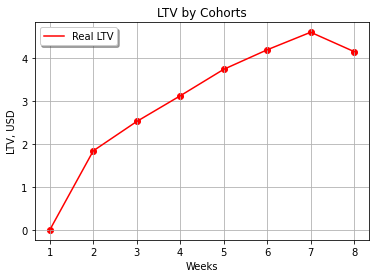

In [2]:
#импорт необходимых библиотек для вывода графика зависимости LTV от времени (разбито по когортам)
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
#x = np.arange(1, len(cohort_begin)+1)
x=array(range(1, len(cohort_begin)+1))
y = array([LTV])

plt.scatter(x, y, color = 'red' )
plt.plot([i for i in range(1, len(cohort_begin)+1)], LTV, color = 'red', label="Real LTV")
plt.title('LTV by Cohorts')
plt.xlabel('Weeks')
plt.ylabel('LTV, USD')
plt.legend(loc = 'best', fancybox = True, shadow = True) 
plt.grid(True)
plt.show()

Выше график расчетного LTV по предоставленным данным.

#### Прогнозирование LTV на полгода

Для расчета прогнозируемого LTV из существующих данных нужно удалить 5 % верхних и 5 % нижних выпадающих показателей, которые могут исказить среднюю тенденцию. Тк мы уже видим, что данные у нас за 8 недель, я сделала удаление первой и последней строки.


In [3]:
#удаление краевых значений, чтобы избежать искажения средней тенденции 
optim_LTV=LTV
optim_LTV.pop(0)
optim_LTV.pop()

4.156804061640604

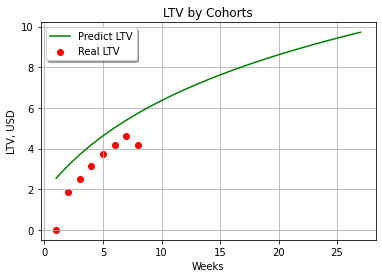

In [4]:
from scipy.optimize import curve_fit
from numpy import log 

weeks=array(range(len(cohort_begin)-2))
#определение целевой функции, выбрала логарифмическую, тк она дает лучшие результаты на 5-6 месяцев

def mapping(weeks, a, b,c): 
    return a *log(weeks + b)+c 

args, _ = curve_fit(mapping, weeks, optim_LTV) 
a, b, c = args[0], args[1],  args[2]
predict_weeks=array(range(1,28))
predict_LTV = a * log(predict_weeks+ b)+c

plt.scatter(x, y, color = 'red',label="Real LTV" )
plt.plot(predict_weeks, predict_LTV, label="Predict LTV", color = 'green') 
plt.title('LTV by Cohorts')
plt.xlabel('Weeks')
plt.ylabel('LTV, USD')
plt.legend(loc = 'best', fancybox = True, shadow = True) 
plt.grid(True) 
plt.show() 

Выше график расчетного LTV по предоставленным данным (красным цветом) и график прогнозируемого LTV (зеленыого цвета).


#### Расчет ROMI
Cтоимость привлечения платящего пользователя 6 USD.

*Расчет ROMI на 4 недели*

In [5]:
User_cost=6
weeks_for_calc=4

ROMI=((weeks_for_calc-1)*subscription-User_cost)/User_cost*100

print('ROMI for',weeks_for_calc,'weeks is',round(ROMI, 2), '%')

ROMI for 4 weeks is 149.5 %


*Расчет ROMI на полгода (~27 недель)*

In [6]:
weeks_for_calc=27

ROMI=((weeks_for_calc-1)*subscription-User_cost)/User_cost*100

print('ROMI for',weeks_for_calc,'weeks is',round(ROMI, 2), '%')

ROMI for 27 weeks is 2062.33 %
